In [1]:
!which python 
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/miniconda3/envs/main/bin/python
farshed.abdukhakimov
cn-09
/home/farshed.abdukhakimov/projects/sania


In [2]:
%load_ext autoreload
%autoreload 2

import os
import datetime
import time
from collections import defaultdict

import numpy as np
import numba

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from experiments import utils
from experiments.loss_functions import LogisticRegressionLoss, BaseOracle
from experiments.methods import *

import scipy
# import optuna 

import svmlight_loader

from dotenv import load_dotenv
load_dotenv()

/home/farshed.abdukhakimov/miniconda3/envs/main/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


True

In [3]:
np.random.seed(0)
n = 10000
d = 200

data, target = utils.make_synthetic_binary_classification(n, d)
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=0)

scale = 4
scaling_vec = utils.generate_scaling_vec(size=train_data.shape[1], scale=scale)
scaled_train_data = scaling_vec * train_data
scaled_test_data = scaling_vec * test_data

dataset = train_data, train_target, test_data, test_target
scaled_dataset = scaled_train_data, train_target, scaled_test_data, test_target

In [4]:
def train_loop(dataset: list[np.ndarray], 
               batch_size: int, 
               n_epochs: int,
               optimizer:BaseOptimizer,
               seed: int = 0,
               **optimizer_kwargs) -> dict: 

    np.random.seed(seed)
    
    train_data, train_target, test_data, test_target = dataset
    
    # parameters
    params = np.zeros(train_data.shape[1])
    optim = optimizer(params, **optimizer_kwargs)

    # oracle 
    loss_function = LogisticRegressionLoss()
    
    # logging 
    history = defaultdict(list)

    indices = np.arange(train_data.shape[0])
    
    for epoch in range(n_epochs):
        
        # Evaluation 
        loss, grad, acc = loss_function.func_grad_acc(params, test_data, test_target)
        g_norm = np.linalg.norm(grad)**2
        history["test/loss"].append(loss)
        history["test/acc"].append(acc)
        history["test/grad_norm"].append(g_norm)
        

        # Training 
        np.random.shuffle(indices)

        for idx in range(train_data.shape[0]//batch_size):
            batch_indices = indices[idx*batch_size:(idx+1)*batch_size]
            batch_data = train_data[batch_indices]
            batch_target = train_target[batch_indices] 
        
            train_loss, train_grad, _ = loss_function.func_grad_acc(params, batch_data, batch_target)
            
            optim.step(loss=train_loss, grad=train_grad)
            
        # print(f"Epoch [{epoch}/{n_epochs}] | Train Loss: {epoch_loss} | Val Loss: {val_loss}")
        # print(f"Val GradNorm**2: {val_g_norm} | Train GradNorm**2: {epoch_grad_norm}")
        # print(f"Val Acc: {val_acc} | Train Acc: {epoch_acc}\n")
        
        
    # Evaluation 
    loss, grad, acc = loss_function.func_grad_acc(params, test_data, test_target)
    g_norm = np.linalg.norm(grad)**2
    history["test/loss"].append(loss)
    history["test/acc"].append(acc)
    history["test/grad_norm"].append(g_norm)
    
    # print(f"Test Loss: {test_loss} | Test Acc: {test_acc} | Test GradNorm**2: {test_g_norm}")
    
    return history

In [ ]:
n_epochs = 100
batch_size = 20

optimizers = [SANIA_AdagradSQR, SANIA_AdagradSQR, SANIA_AdagradSQR, SANIA_AdagradSQR, SANIA_AdamSQR, SANIA_AdamSQR, SANIA_AdamSQR, SANIA_AdamSQR]
sqrts = [True, True, False, False, True, True, False, False]
scales = [0, scale, 0, scale, 0, scale, 0, scale]

dataset_name = f"binary_classification_synthetic_{n}x{d}"
all_histories = []

for optimizer, sqrt, scale in zip(optimizers, sqrts, scales):
    
    if scale > 0:
        t_dataset = scaled_dataset
    else:
        t_dataset = dataset
        
    if sqrt:
        optimizer_name = optimizer.__name__[:-3]
    else:
        optimizer_name = optimizer.__name__
    
    print(optimizer_name)
    
    histories = []

    for seed in [0, 1, 2, 3, 4]:
        hist = train_loop(dataset=t_dataset, 
                        batch_size=batch_size, 
                        n_epochs=n_epochs, 
                        optimizer=optimizer,
                        seed=seed, 
                        eps=0.0, 
                        is_sqrt=sqrt,
                        )
        
        utils.save_results(results=hist, 
                           model_name="linear", 
                           dataset_name=dataset_name,
                           scale=scale, 
                           batch_size=batch_size,
                           n_epochs=n_epochs,
                           optimizer=optimizer_name,
                           lr=1.0,
                           seed=seed)
        
        histories.append(hist)
        
    all_histories.append(histories)

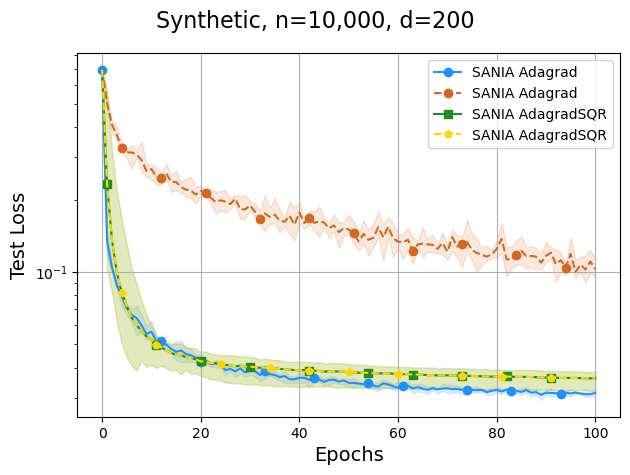

In [8]:
model_name = "linear"
n_epochs = 100
batch_size = 20
dataset_name = f"binary_classification_synthetic_{n}x{d}"


methods = ["SANIA_Adagrad", "SANIA_Adagrad", "SANIA_AdagradSQR", "SANIA_AdagradSQR"]
lrs = [1.0, 1.0, 1.0, 1.0, 1.0]
scales = [0, scale, 0, scale]
linestyles = ["-", "--", "-", "--"]
markers = ["o", "o", "s", "p"]
colors = ["dodgerblue", "chocolate", "forestgreen", "gold", "orangered", "navy", "purple", "lime"]
linewidths = [1.5, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 1.5]
suptitle = f"Synthetic, n={n:,}, d={d}"
labels = ["SANIA Adagrad", "SANIA Adagrad", "SANIA AdagradSQR", "SANIA AdagradSQR"]


utils.plot_loss(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name, 
        methods=methods, lrs=lrs, scales=scales, labels=labels, colors=colors, linestyles=linestyles, 
        linewidths=linewidths, markers=markers, suptitle=suptitle, 
        threshold=0.0, tight_layout=True, 
        filename=f"{dataset_name}_{model_name}_{batch_size}_SANIA_AdagradSQR.pdf"
        )

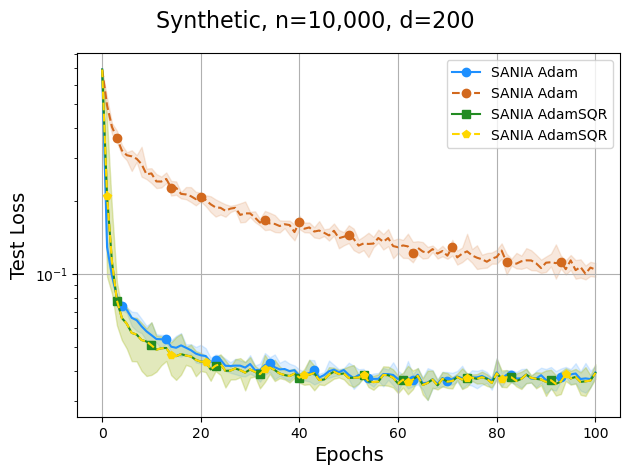

In [9]:
model_name = "linear"
n_epochs = 100
batch_size = 20
dataset_name = f"binary_classification_synthetic_{n}x{d}"


methods = ["SANIA_Adam", "SANIA_Adam", "SANIA_AdamSQR", "SANIA_AdamSQR"]
lrs = [1.0, 1.0, 1.0, 1.0, 1.0]
scales = [0, scale, 0, scale]
linestyles = ["-", "--", "-", "--"]
markers = ["o", "o", "s", "p"]
colors = ["dodgerblue", "chocolate", "forestgreen", "gold", "orangered", "navy", "purple", "lime"]
linewidths = [1.5, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 1.5]
suptitle = f"Synthetic, n={n:,}, d={d}"
labels = ["SANIA Adam", "SANIA Adam", "SANIA AdamSQR", "SANIA AdamSQR"]


utils.plot_loss(dataset_name=dataset_name, batch_size=batch_size, n_epochs=n_epochs, model_name=model_name, 
        methods=methods, lrs=lrs, scales=scales, labels=labels, colors=colors, linestyles=linestyles, 
        linewidths=linewidths, markers=markers, suptitle=suptitle, 
        threshold=0.0, tight_layout=True, 
        filename=f"{dataset_name}_{model_name}_{batch_size}_SANIA_AdamSQR.pdf",
        )

In [11]:
labels = ["SANIA Adagrad", "SANIA Adagrad", "SANIA AdagradSQR", "SANIA AdagradSQR"]
colors = ["dodgerblue", "chocolate", "forestgreen", "gold", "orangered", "navy", "purple", "lime"]
linestyles = ["-", "--", "-", "--", "-", "--", "-", "--"]
linewidths = [1.5, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 1.5]
markers = ["o", "o", "s", "p", "8", "8", "P", "H"]

plotter(histories=all_histories,
        labels=labels, 
        colors=colors,
        linestyles=linestyles,
        linewidths=linewidths,
        markers=markers,
        suptitle=f"Synthetic, n={n:,}, d={d}",
        filename="experiments/plots/synthetic_scale_invariance_sania_adalike.pdf"
        )

NameError: name 'all_histories' is not defined

In [ ]:
labels = ["SANIA Adagrad", "SANIA Adagrad", "SANIA AdagradSQR", "SANIA AdagradSQR", 
          "SANIA Adam", "SANIA Adam", "SANIA AdamSQR", "SANIA AdamSQR"]
colors = ["dodgerblue", "chocolate", "forestgreen", "gold", "orangered", "navy", "purple", "lime"]
linestyles = ["-", "--", "-", "--", "-", "--", "-", "--"]
linewidths = [1.5, 1.5, 1.5, 1.5, 1.0, 1.5, 1.5, 1.5]
markers = ["o", "o", "s", "p", "8", "8", "P", "H"]

plotter(histories=all_histories,
        labels=labels, 
        colors=colors,
        linestyles=linestyles,
        linewidths=linewidths,
        markers=markers,
        suptitle=f"Synthetic, n={n:,}, d={d}",
        filename="experiments/plots/synthetic_scale_invariance_sania_adalike.pdf"
        )